# Body sign  

日常生活中，人们常常使用手势来表达想法。利用机器学习的方法，可以高效、准确、快速地识别人们的手势。  
本项目利用TensorFlow编写了可以用来识别手势的模型，通过fine-turning的方法，在MobileNetv2模型的基础上快速生成手势识别模型，取得了非常好的效果。

|1|2|
|---|---|
|<img src="./Dataset/1/IMG20200814110405_01.jpg"/>|<img src="Dataset/2/IMG20200814110642_01.jpg"/>|

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers,datasets
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense,Activation
import math
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

## 设计网络  
使用预训练的MobileNetV2模型  
MobileNetV2模型在imagenet上预训练后可以对图像的语义从低级到高级提取特征。  
根据手势识别数据的观察，我们发现这个数据集的图像相对简单，MobileNetV2模型有能力提取这些特征，所以我们直接使用tfhub中保存的预训练的模型。  
  
以训练好的模型的可训练参数设置为False，这样对于基础模型的各个参数，在训练中不会发生变化。

<center>

    
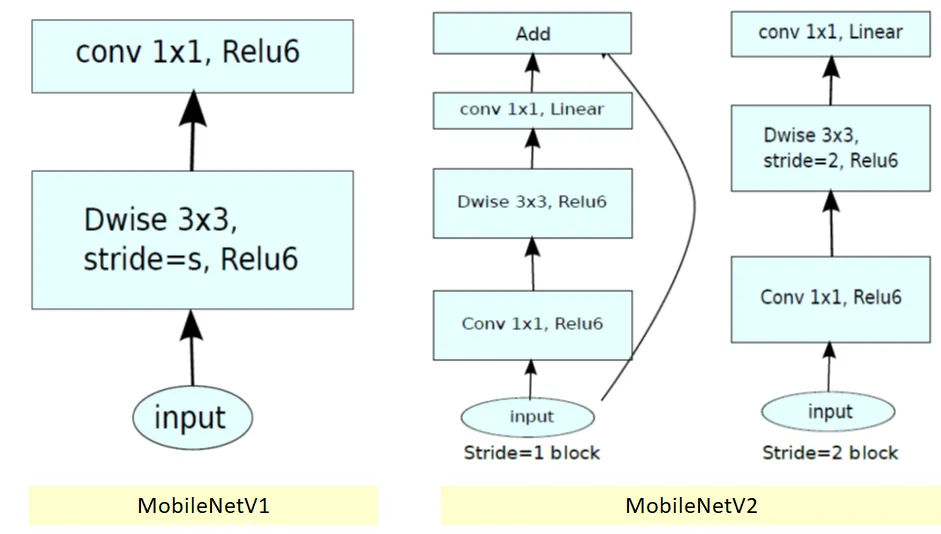


    </center>

In [2]:
feature_extractor_url = "./tf2-preview_mobilenet_v2_feature_vector_4"
# feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,input_shape=(224,224,3))
# 这一层的训练值保持不变
feature_extractor_layer.trainable = False

2023-10-24 15:27:56.120987: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 15:27:56.998768: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10396 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
2023-10-24 15:27:56.999303: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10410 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


从Dataset中设定数据预处理。  
预处理包括数据的拉伸、变形、旋转和归一化等操作。  
通过这些预处理可以让图像变得多元化，这对降低模型的高拟合度非常有好处。

In [3]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255, 
    validation_split=0.1,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    samplewise_center=True,
    samplewise_std_normalization=True,
    featurewise_center=True,
    featurewise_std_normalization=True)

训练的周期

In [4]:
epochs = 50

每批次训练的样本个数

In [5]:
batch_size = 8

数据集文件夹

In [6]:
train_data_dir = 'Dataset'

In [7]:
img_width,img_height=224,224

从预处理数据中提取训练数据，约占90%

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

Found 1023 images belonging to 10 classes.


验证集约占整个数据的10%

In [9]:
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

Found 110 images belonging to 10 classes.


提取标签值

In [10]:
train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=len(train_generator.class_indices))
train_generator.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

fine-tuning的核心是在基础模型的顶层增加一些神经网络层，   
这样在高级语义方面专门训练模型对手势的认识。  
这里再mobilenetv2基础上增加了3个全连接层。  

In [11]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(10, activation='softmax')
])

设置损失函数，这里使用categorical_crossentropy

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 2,980,810
Trainable params: 722,826
Non-tr

这里可以指明模型的保存路径  
并且利用回调函数，显示地进行模型的保存。

In [13]:
checkpoint_path = "cp_2023/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [14]:
n_train_images = train_generator.n
n_val_images = validation_generator.n
nb_steps_per_epoch = int(n_train_images/batch_size)
validation_steps = int(n_val_images/batch_size)

## 训练模型  
workers一般设置为系统能够使用线程数量，比如本机的CPU为12线程，这里就设置为12

In [15]:
history = model.fit(
    train_generator,
    # shuffle=True,
    workers= 12,
    epochs = epoch,
    validation_data = validation_generator,
    callbacks=[cp_callback]
    )

Epoch 1/50


/home/heng/anaconda3/envs/tf/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/heng/anaconda3/envs/tf/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
2023-10-24 15:30:25.425868: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201
2023-10-24 15:30:25.642407: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


128/128 [==============================] - ETA: 0s - loss: 1.2710 - accuracy: 0.5699
Epoch 1: saving model to cp_2023/cp.ckpt
128/128 [==============================] - 7s 27ms/step - loss: 1.2710 - accuracy: 0.5699 - val_loss: 0.5120 - val_accuracy: 0.7636
Epoch 2/50
126/128 [============================>.] - ETA: 0s - loss: 0.4749 - accuracy: 0.8272
Epoch 2: saving model to cp_2023/cp.ckpt
128/128 [==============================] - 3s 21ms/step - loss: 0.4721 - accuracy: 0.8289 - val_loss: 0.3338 - val_accuracy: 0.8182
Epoch 3/50
125/128 [============================>.] - ETA: 0s - loss: 0.3151 - accuracy: 0.8859
Epoch 3: saving model to cp_2023/cp.ckpt
128/128 [==============================] - 3s 21ms/step - loss: 0.3160 - accuracy: 0.8837 - val_loss: 0.2025 - val_accuracy: 0.9000
Epoch 4/50
128/128 [==============================] - ETA: 0s - loss: 0.2183 - accuracy: 0.9150
Epoch 4: saving model to cp_2023/cp.ckpt
128/128 [==============================] - 3s 21ms/step - loss: 0.2

保存训练过程中每个阶段的值，用来统计分析

In [16]:
import pickle
with open('cp_2023/mbv2.history.pickle', 'wb') as f:
    pickle.dump(history.history, f)

将最终的模型保存为h5格式。  
训练好的模型有多种保存格式，h5格式只是其中的一种，可以根据使用选择格式

In [17]:
model.save('cp_2023/mbv2.h5')

这里尝试将模型保存为tensorflow lite格式  
TensorFlow lite对于移动应用友好，可以将这个应用移植到手机上。

In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("cp_2023/float_mbv2.tflite", "wb").write(tflite_model)

2023-10-24 15:33:49.616802: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmp6e45dhty/assets


2023-10-24 15:33:56.967311: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-10-24 15:33:56.967346: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-10-24 15:33:56.968026: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp6e45dhty
2023-10-24 15:33:56.980275: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-10-24 15:33:56.980299: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmp6e45dhty
2023-10-24 15:33:57.035287: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-10-24 15:33:57.440506: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmp6e45dhty
2023-10-24 15:33:57.605573: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 637549 

11759484

尝试对模型进一步进行压缩，这样有助于在手机等边界设备上运行。

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.post_training_quantize = True
tflite_quantized_model = converter.convert()
open("cp_2023/quantized_mbv2.tflite", "wb").write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpk_9a3jes/assets


INFO:tensorflow:Assets written to: /tmp/tmpk_9a3jes/assets
2023-10-24 15:34:26.907153: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-10-24 15:34:26.907189: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-10-24 15:34:26.907381: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpk_9a3jes
2023-10-24 15:34:26.919614: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-10-24 15:34:26.919641: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpk_9a3jes
2023-10-24 15:34:26.976013: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-10-24 15:34:27.383056: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpk_9a3jes
2023-10-24 15:34:27.551381: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

11759484